In [4]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import numpy as np
import copy
import pickle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 250

In [5]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [8]:
NORMALIZE = False
# file_type = "../data/Raman_Mouse/"
file_type = "../data/Green_excitation/"

file_location = f"{file_type}approximated/"
file_location_org = f"{file_type}corrected_4_wavenumbers/"

filenames = np.load(f"{file_location_org}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)

vector_norm = unit_vector_norm if NORMALIZE else lambda x: x
    
data = []
split_data = []
for f in filenames:
    raw = np.load(f"{file_location_org}{f.split('.')[0]}.npy")
    data.append(vector_norm(raw.reshape(-1,raw.shape[-1])).reshape(raw.shape))
    
    photo = np.load(f"{file_location}{f.split('.')[0]}_photoluminescence.npy")
    raman = np.load(f"{file_location}{f.split('.')[0]}_raman.npy")
    split_data.append((raman,photo,labels[f]))

In [9]:
rng = np.random.default_rng()

class Kalman():    
    def __init__(self, X, grad, e, neighbourhood, photo_smoothness = 5000, noise_smoothness = 2, correct_photo_appr_blacknoise=True):
        self.X = X
        self.N_wavenumbers = self.X.shape[0]
        self.N_photo_appr = X.shape[1] - 1
        self.photo_smoothness = photo_smoothness
        self.noise_smoothness = noise_smoothness
        
        self.C = np.array([[1,1]] +
                           [[1,0]] * self.N_photo_appr)
        self.A = np.zeros((self.N_wavenumbers, 2, 2))
        self.A[:,0,0] = grad
        self.A[:,1,1] = 1
        
        if correct_photo_appr_blacknoise:
            self.e = np.array([e] * X.shape[1])
        else:
            self.e = np.array([e] + [0] * self.N_photo_appr)
            
        self.n = neighbourhood
        self.mu = np.empty((self.N_wavenumbers, 2))
        self.M = np.empty((self.N_wavenumbers, 2, 2))
        self.nu = np.empty((self.N_wavenumbers+1, 2))
        self.V = np.empty((self.N_wavenumbers+1, 2, 2))
        self.J = np.empty((self.N_wavenumbers, 2, 2))

        self.nu[0] = [X[0,0], 0]
        
        self.Sigma = np.diag(rng.standard_normal(1 + self.N_photo_appr))
        self.Gamma = np.diag(rng.standard_normal(2))
        self.V[0] = [[0, 0],
                     [0, 0]]
    
    @property
    def raw_data(self):
        return self.X, self.A[:,0,0]
    
    @raw_data.setter
    def raw_data(self, args):
        value, grad = args
        self.X = value
        self.nu[0] = [self.X[0,0], 0]
        self.A[:,0,0] = grad
        self.EM(1)
        
    def _filter_step(self, i):
        CV = self.C @ self.V[i]
        b = self.C @ self.nu[i] + self.e
        B = CV @ self.C.T + self.Sigma 
        K = self.V[i] @ self.C.T @ np.linalg.inv(B)
        self.mu[i] = self.nu[i] + K @ (self.X[i] - b)
        self.M[i] = self.V[i] - K @ CV

        # transition
        self.nu[i+1] = self.A[i] @ self.mu[i]
        self.V[i+1] = self.A[i] @ self.M[i] @ self.A[i] + self.Gamma # A = A.T
        
    def _smoother_step(self, i):
        self.J[i] = self.M[i-1] @ self.A[i] @ np.linalg.inv(self.V[i])
        self.M[i-1] += self.J[i] @ (self.M[i] - self.V[i]) @ self.J[i].T
        self.mu[i-1] += self.J[i] @ (self.mu[i] - self.nu[i])
    
    def kalman_filter(self):
        for i in range(len(self.X)):
            self._filter_step(i)
            
    def kalman_smoother(self):
        self.kalman_filter()
        
        for i in range(len(self.X)-1, 0, -1):
            self._smoother_step(i)
            
    def EM(self, n):
        lst = [copy.copy(self.A[:,0,0])]
        lst2 = []
        for i in range(n):
            self.kalman_smoother()
            E_z = self.mu
            E_zz = self.M + self.mu.reshape(-1,self.mu.shape[1],1) @ self.mu.reshape(-1,1,self.mu.shape[1])
            E_z_1z = (self.J @ self.M)[1:] + self.mu[:-1].reshape(-1,self.mu.shape[1],1) @ self.mu[1:].reshape(-1,1,self.mu.shape[1])

            # skip nu_0, V_0, A and C
            self.Gamma = np.sum(E_zz[1:] - 
                                E_z_1z.transpose(0,2,1) @ self.A[:-1].transpose(0,2,1) - 
                                self.A[:-1] @ E_z_1z + 
                                self.A[:-1] @ E_zz[:-1] @ self.A[:-1].transpose(0,2,1),
                                0) / self.N_wavenumbers
    
            self.Sigma = (self.X.T @ self.X - 
                         self.C @ E_z.T @ self.X - 
                         self.X.T @ E_z @ self.C.T + 
                         np.sum(self.C @ E_zz @ self.C.T, 0)) / (self.N_wavenumbers + 1)
            
            # make covarience diagonal
            self.Sigma = np.diag(np.diag(self.Sigma)) 
            self.Sigma[0,0] /= self.noise_smoothness
            self.Sigma[0,0] += 1e-3
            
            c = (self.Gamma[0,0] + self.Gamma[1,1]) / self.photo_smoothness
            self.Gamma = np.diag([c, c*(self.photo_smoothness-1)])
            
            
def split_signal(img, photo_smoothness=10, noise_smoothness = 2):
    black_noise = 0
    
    x = img.reshape(-1, img[0].shape[-1])
    grad = np.ones(x.shape[1])

    obj = Kalman(np.stack((x[0], x[0])).T, grad, black_noise, 1, photo_smoothness=photo_smoothness, noise_smoothness=noise_smoothness)
    obj.EM(10)
    
    raman = np.empty(x.shape)
    photo = np.empty(x.shape)
    
    for pixel in range(x.shape[0]):   
        obj.raw_data = np.stack((x[pixel], x[pixel])).T, grad
        
        raman[pixel] = obj.mu[:,1]
        photo[pixel] = obj.mu[:,0]
        
    return raman, photo, x

In [10]:
import timeit
from os import path
from scipy import stats

file_location2 = "../data/Raman_Mouse/black_noise_removed/"
shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue
    sm = 10
    blacknoise, raman, x = split_signal(img, photo_smoothness=sm, noise_smoothness = 20)
    
#     for pixel in range(x.shape[0]):  
#         plt.title(f"smoothing is {sm}")
#         plt.plot(x[pixel], label='raw')
#         plt.plot(raman[pixel], label='raman')
#         plt.plot(photo[pixel], label='photo')
#         plt.plot(photo[pixel]+raman[pixel], label='reconstruction', alpha=.3)
#         plt.plot([0,1300],[0,0], 'k', alpha=0.3)
#         plt.xlim(0,1300)
#         plt.ylim(-100,5000)
#         plt.legend()
#         plt.show()
#         break

    stop = timeit.default_timer()
    print('Time: ', stop - start)
    break
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
#     print(f"image: {f} is done.")
    

Time:  149.71952384500014


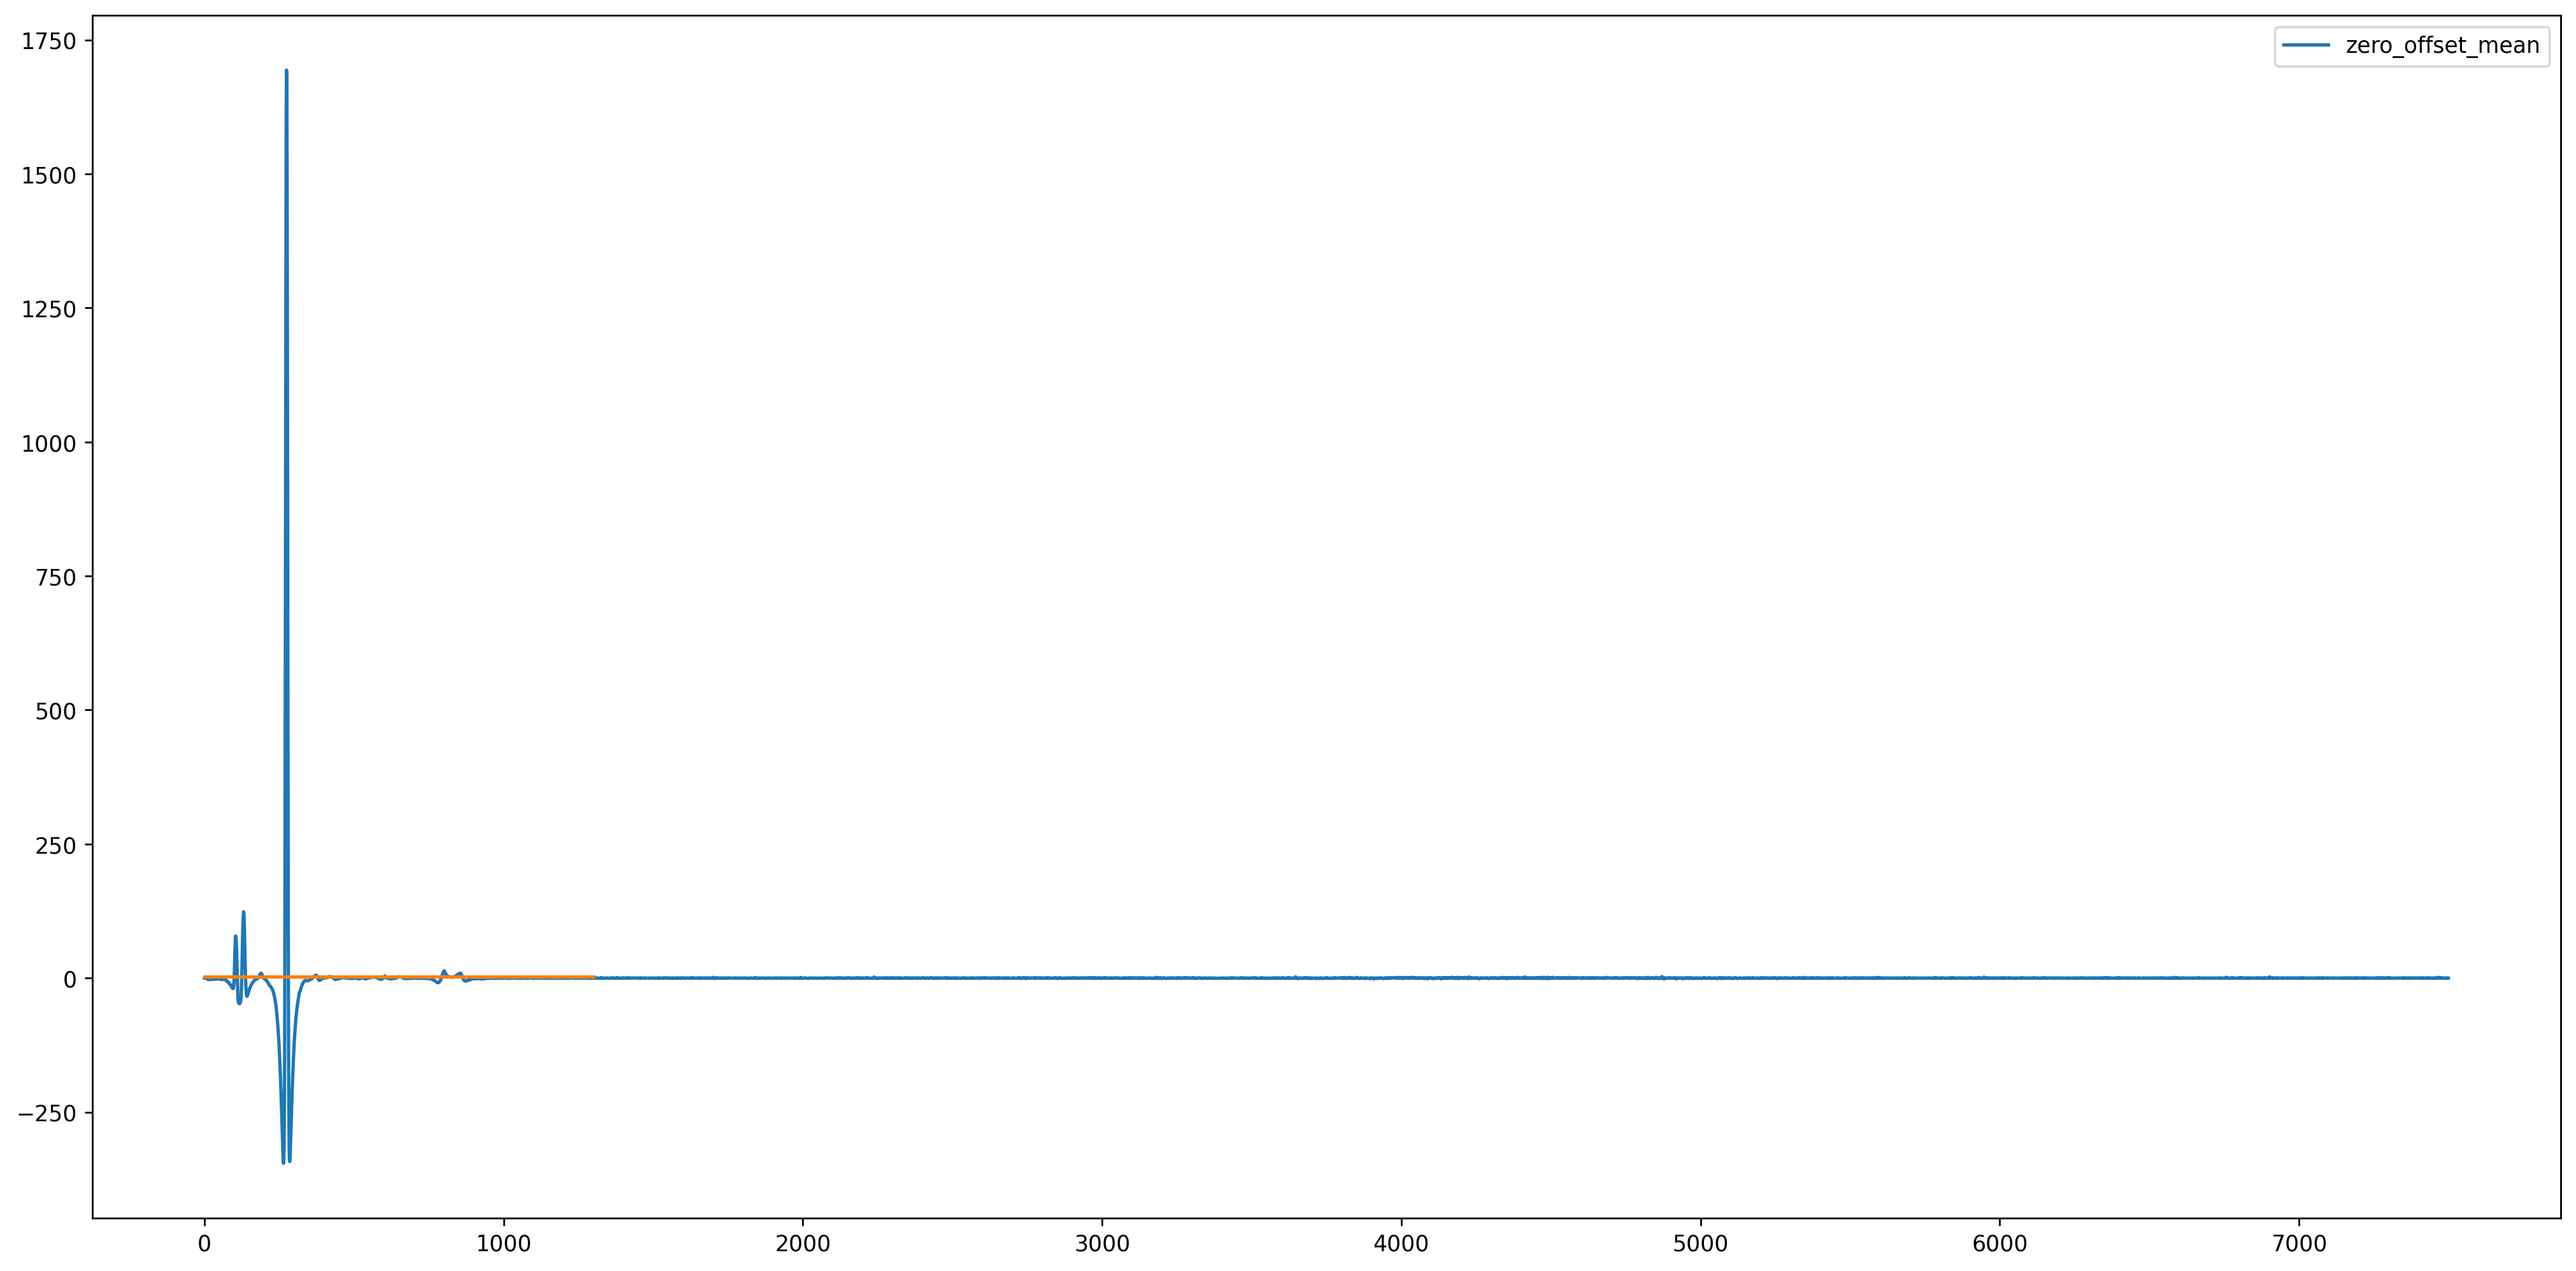

In [11]:
pixel_mean = np.mean(blacknoise, 1)
zero_offset_blacknoise =  blacknoise - pixel_mean[:,None]
avg_spikes = np.mean(zero_offset_blacknoise, 0)
threshold = 3

plt.plot(avg_spikes,label="zero_offset_mean")
plt.plot([0,1300],[threshold, threshold])
plt.legend()
plt.show()


In [13]:
from scipy.optimize import curve_fit
import scipy.signal
import timeit

In [14]:
def gaussian(x, *params):
    mu = np.array(params[slice(0,len(params),3)]).reshape(1,-1)
    scale = np.array(params[slice(1,len(params),3)])
    sigma = np.array(params[slice(2,len(params),3)])
    return np.sum(scale * np.exp( -((x.reshape(-1,1) - mu)/sigma)**2),1)

def lorenz(x, *params):
    mu = np.array(params[slice(0,len(params),3)]).reshape(1,-1)
    scale = np.array(params[slice(1,len(params),3)])
    gamma = np.array(params[slice(1,len(params),3)])
    return np.sum(scale / np.pi * (gamma / ((x.reshape(-1,1) - mu)**2 + gamma**2)), 1) 

func = gaussian

x = np.arange(1300)

# remove negative numbers
# y = copy.copy(avg_spikes)
# y[y < 0] = 0
# y -= np.min(avg_spikes)
# avg_spikes -= np.min(avg_spikes)
# min_spike_height = 0
min_spike_width, max_spike_width = 1, 15

# find local spikes
local_range = 10
mask = avg_spikes > 1
mask2 = np.ones(mask.shape) * -1
for i, v in enumerate(mask):
    if not v or mask2[i] >= 0:
        continue
    
    # find the maximum of three consecutive values
    j = np.argmax(avg_spikes[i:i+local_range])
    
    # set the maximum value to one the rest to zero
    mask2[i:i+local_range] = 0
    mask2[i+j] = 1

spikes = np.where(mask2 > 0)[0]

print(spikes, len(spikes))

guess = []
lower_bounds = []
upper_bounds = []
# spikes
for i in spikes:
    guess += [i, avg_spikes[i], 2*min_spike_width]
    lower_bounds += [i-2*local_range, 0, min_spike_width]
    upper_bounds += [i+2*local_range, 200, max_spike_width]

# # photo/constant
# for i in range(0, 1300, 100):
#     guess += [i, avg_spikes[i], 100]
#     lower_bounds += [-200, 0, 50]
#     upper_bounds += [1500, 200, 500]

start = timeit.default_timer()
  
popt, pcov = curve_fit(func, x, avg_spikes, p0=guess, bounds=(lower_bounds, upper_bounds))
fit = func(x, *popt)

stop = timeit.default_timer()
print('Time: ', stop - start)  

plt.plot(x, avg_spikes)
plt.plot(x, fit , 'r-')
plt.show()



[   3  104  131  135  189  191  274  279  373  374  415  423  563  568
  603  650  653  801  803  813  825  842  852  855 1305 1700 1840 1993
 2212 2238 2427 3181 3646 3827 3852 3987 3993 4004 4019 4040 4062 4170
 4185 4197 4213 4225 4249 4339 4369 4389 4412 4462 4473 4488 4505 4561
 4603 4685 4768 4824 4851 4871 4967 5343 5590 5783 5947 6395 6582 6756
 6901 7261 7466] 73


ValueError: `x0` is infeasible.

In [15]:
guassian_var = popt.reshape(-1,3)
means = guassian_var[:,0].astype(int)
scales = guassian_var[:,1]
widths = guassian_var[:,2]
print(guassian_var)

NameError: name 'popt' is not defined

In [16]:
mask3 = np.zeros(mask2.shape, dtype=bool)
mask3[means] = 1

# plt.plot([0,1300], [min_spike_height, min_spike_height])
plt.plot(mask2*50, label='threshold')
plt.plot(mask3*25, alpha=0.5, label='fit')
plt.plot(avg_spikes)
plt.legend()
plt.show()


NameError: name 'means' is not defined

Time:  809.7234128


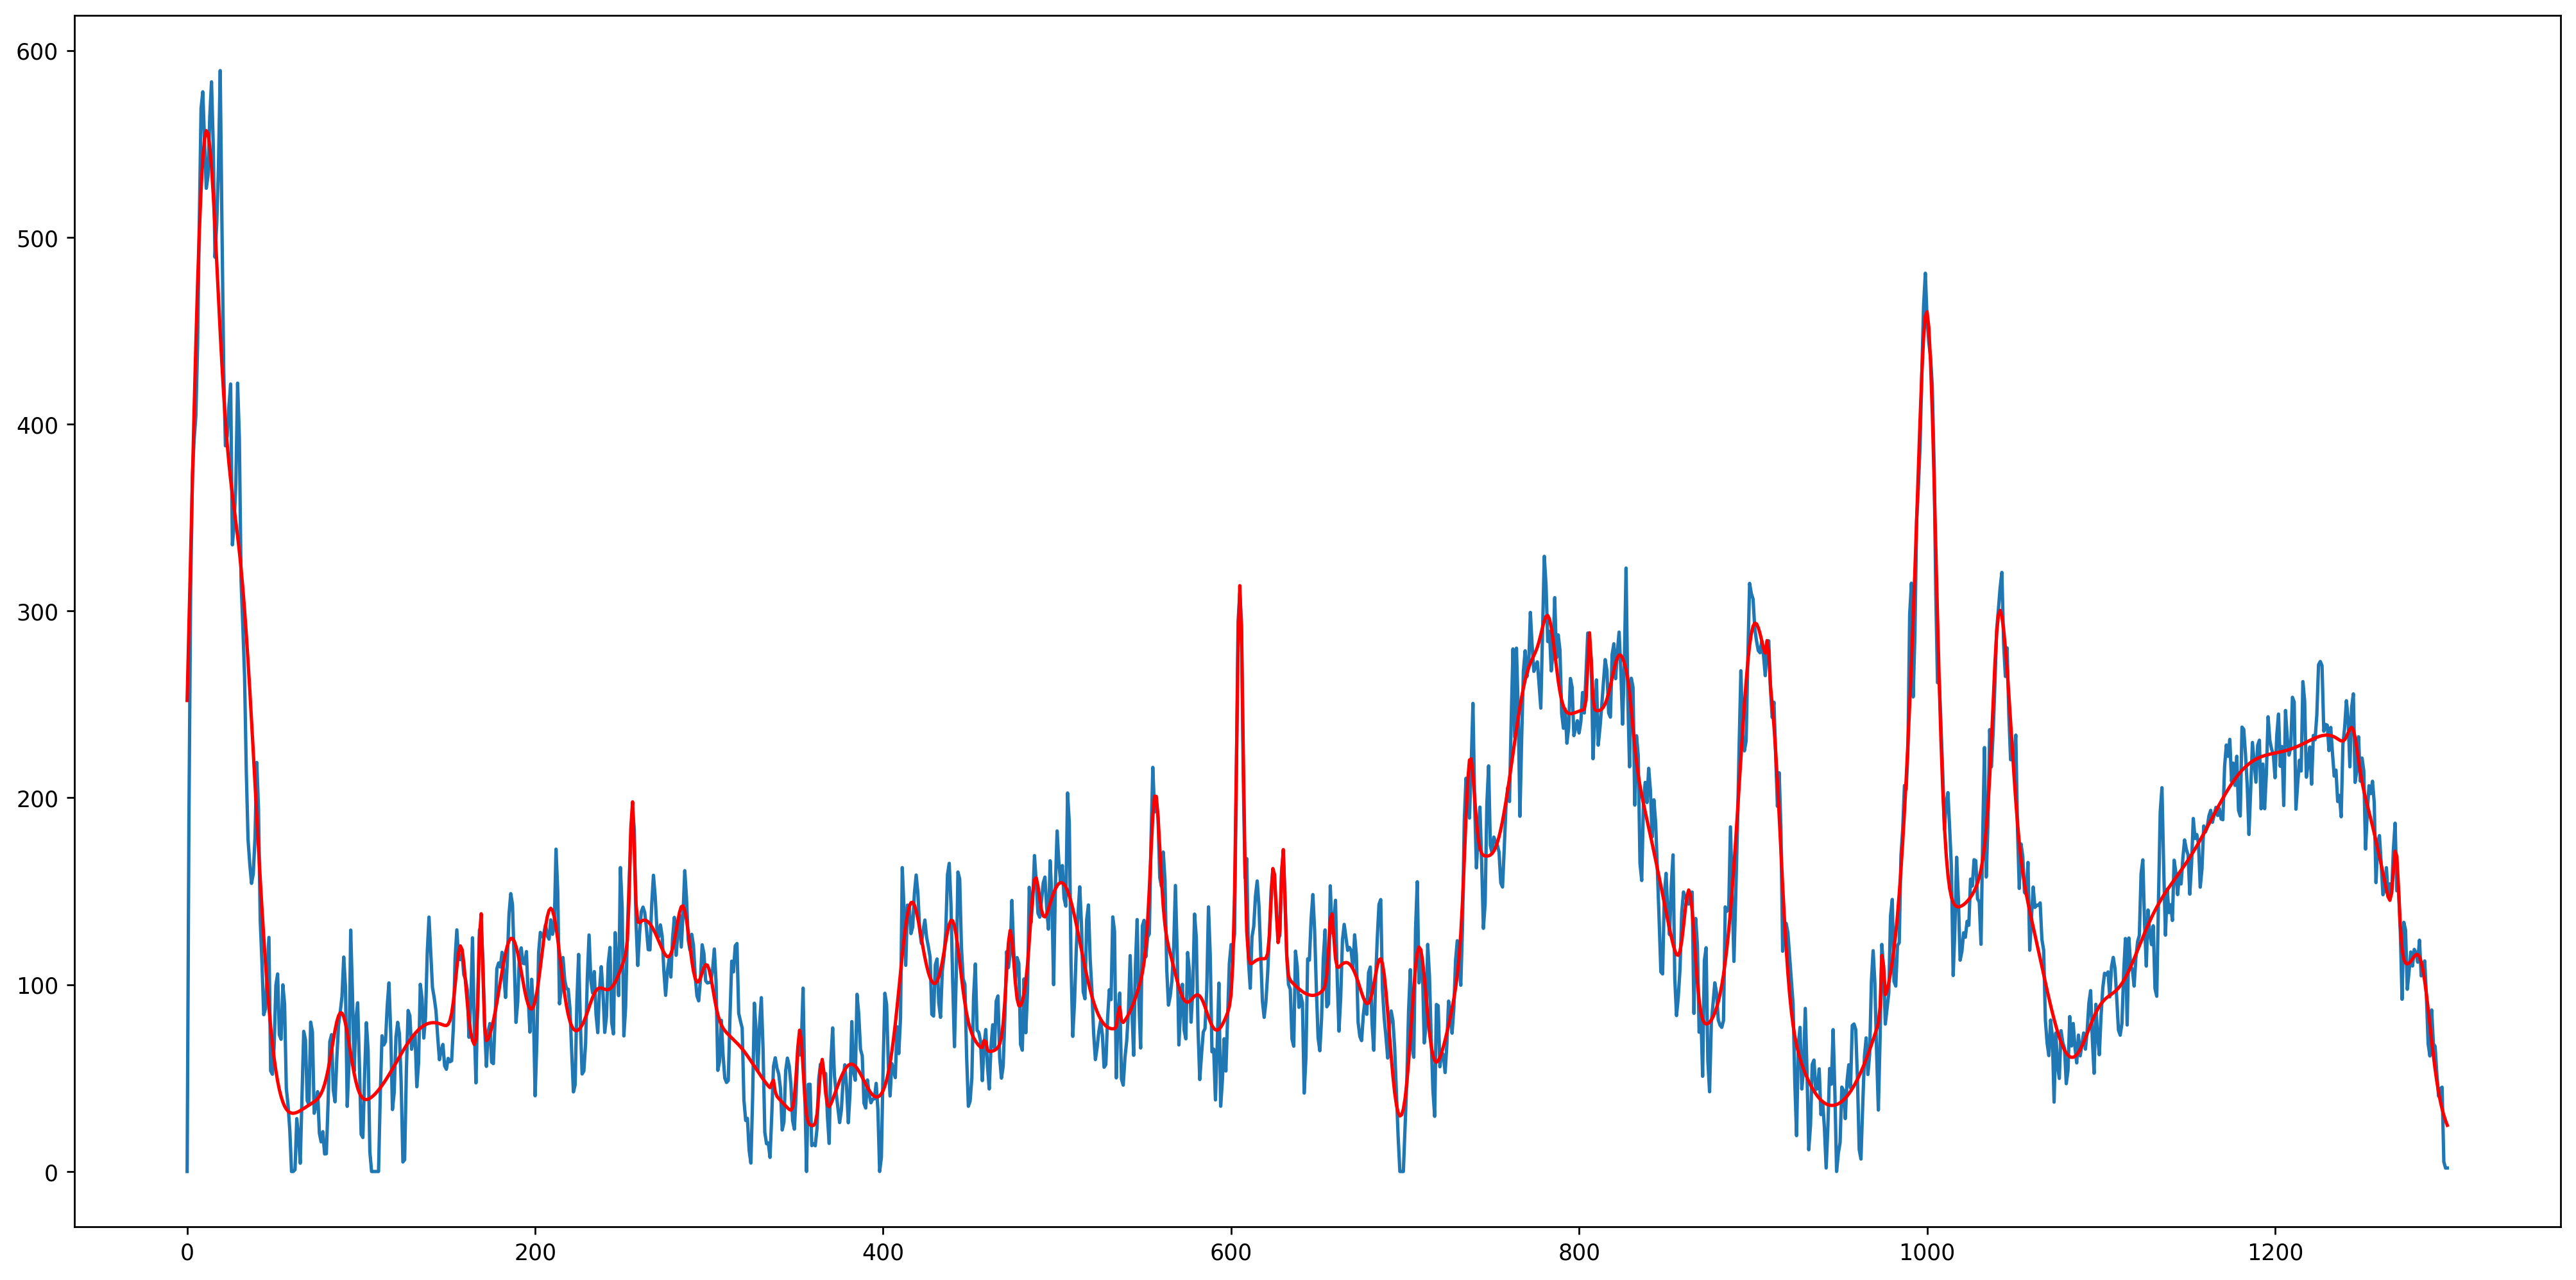

In [26]:
x00 = split_data[0][0][0,0]

# gaussian
guess = []
lower_bounds = []
upper_bounds = []
for mean, scale, width in guassian_var:
    guess += [mean, scale, width]
    lower_bounds += [mean-1, 0, min_spike_width]
    upper_bounds += [mean+1, 1000, max_spike_width]    

# photo/constant
for i in range(0, 1300, 50):
    guess += [i, x00[i], 100]
    lower_bounds += [-200, 0, 30]
    upper_bounds += [1500, 1000, 500]
        
new_scale = []
new_width = []
for y in split_data[0][0].reshape(-1,1300):
    start = timeit.default_timer()
    
    popt2, _ = curve_fit(func, x, y, p0=guess, bounds=(lower_bounds, upper_bounds))
    
    stop = timeit.default_timer()
    print('Time: ', stop - start)     
    
    guassian_var2 = popt2.reshape(-1,3)
    scale = guassian_var2[:,1]
    width = guassian_var2[:,2]
    
    fit = func(x, *popt2)

    plt.plot(x, y)
    plt.plot(x, fit , 'r-')
    plt.show()

    break


Time:  4597.1015917


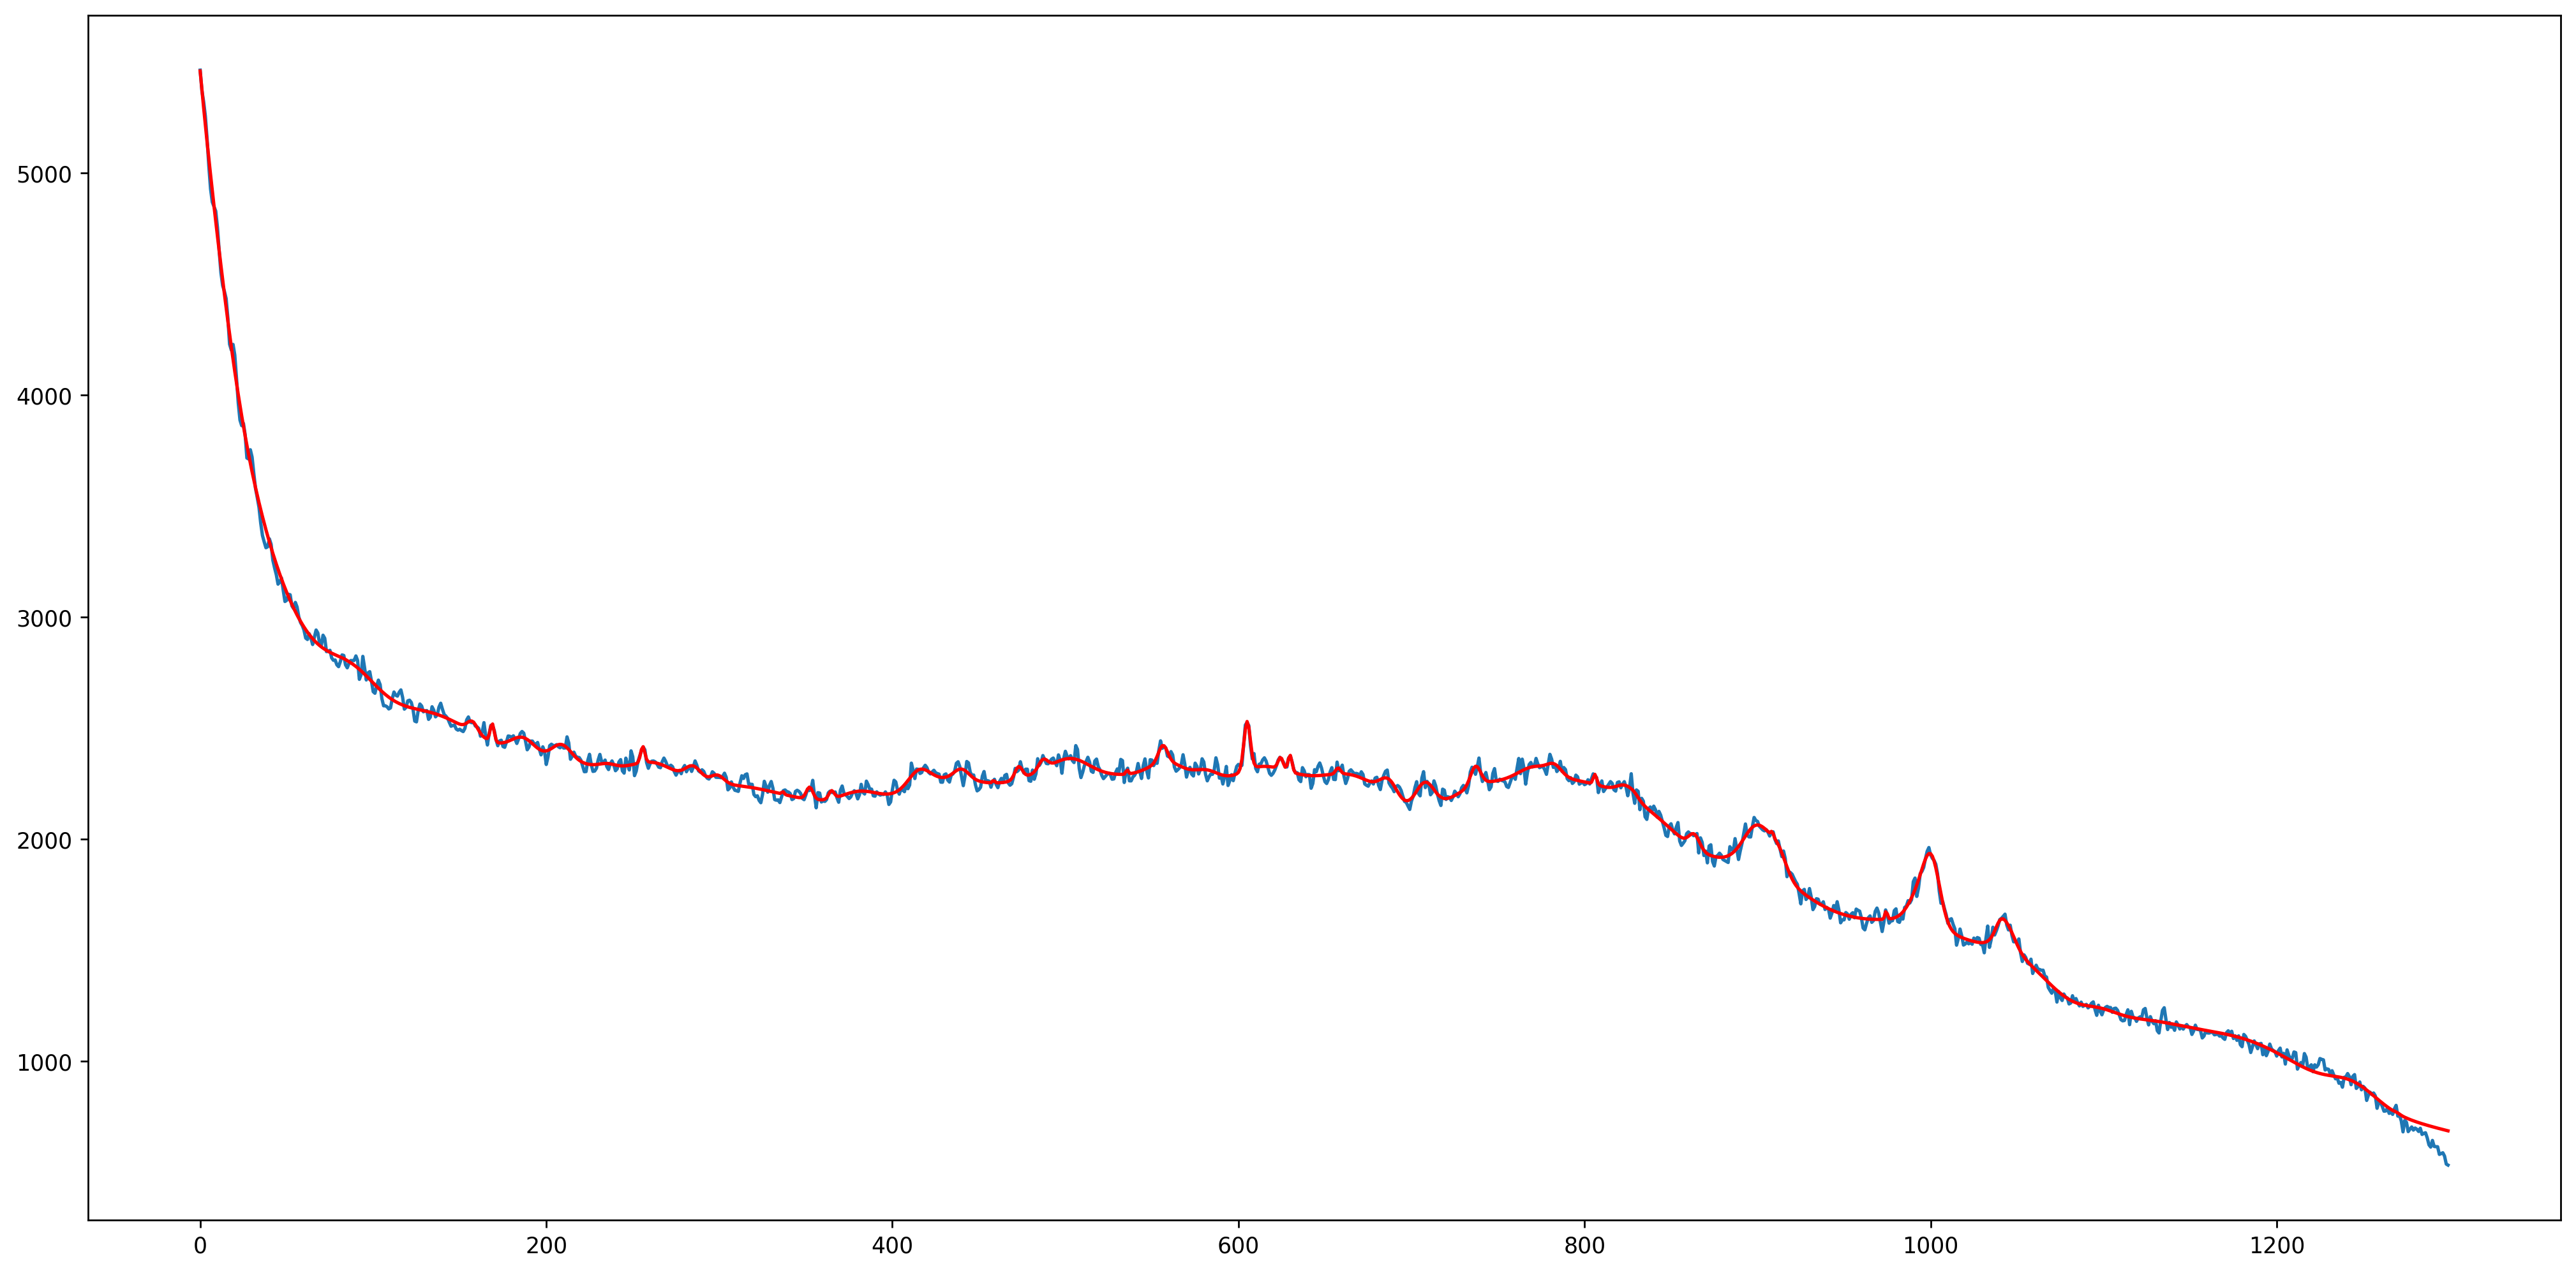

In [167]:
# gaussian
eps = 1e-5
lower_bounds = []
upper_bounds = []
guess =  [-365, 1000000, 150]
guess += [-1400,5000,1800]
guess += [800,750,400]

for val in guess:
    lower_bounds.append(val-eps)
    upper_bounds.append(val+eps)
    
for mean, scale, width in guassian_var2:
    guess += [mean, scale, width]
    lower_bounds += [mean-eps, 0, max(width, min_spike_width)]
    upper_bounds += [mean+eps, 1000, width + max_spike_width]    

# for mean, scale, width in guassian_var2:
# #     if width < max_spike_width:
#     guess += [mean, scale, width]
#     lower_bounds += [mean-1, scale-10, width-1]
#     upper_bounds += [mean+1, scale+10, width+1]    
#     else:
#         guess += [mean, 500, 1000]
#         lower_bounds += [-2000, 0, 300]
#         upper_bounds += [2000, 10000, 2000] 

# # photo/constant
# for i in [-3000,-2500,-2000,-1000,800,1200]:
#     guess += [i, 5000, 500]
#     lower_bounds += [-3000, 0, 300]
#     upper_bounds += [2000, 100000, 2000]

new_scale = []
new_width = []
for y in data[0].reshape(-1,1300):
    start = timeit.default_timer()

    popt3, _ = curve_fit(func, x, y, p0=guess, bounds=(lower_bounds, upper_bounds))

    stop = timeit.default_timer()
    print('Time: ', stop - start)     
    
    guassian_var3 = popt3.reshape(-1,3)
    scale = guassian_var3[:,1]
    width = guassian_var3[:,2]
    
    fit = func(x, *popt3)

    plt.plot(x, y)
    plt.plot(x, fit , 'r-')
    plt.show()

    break

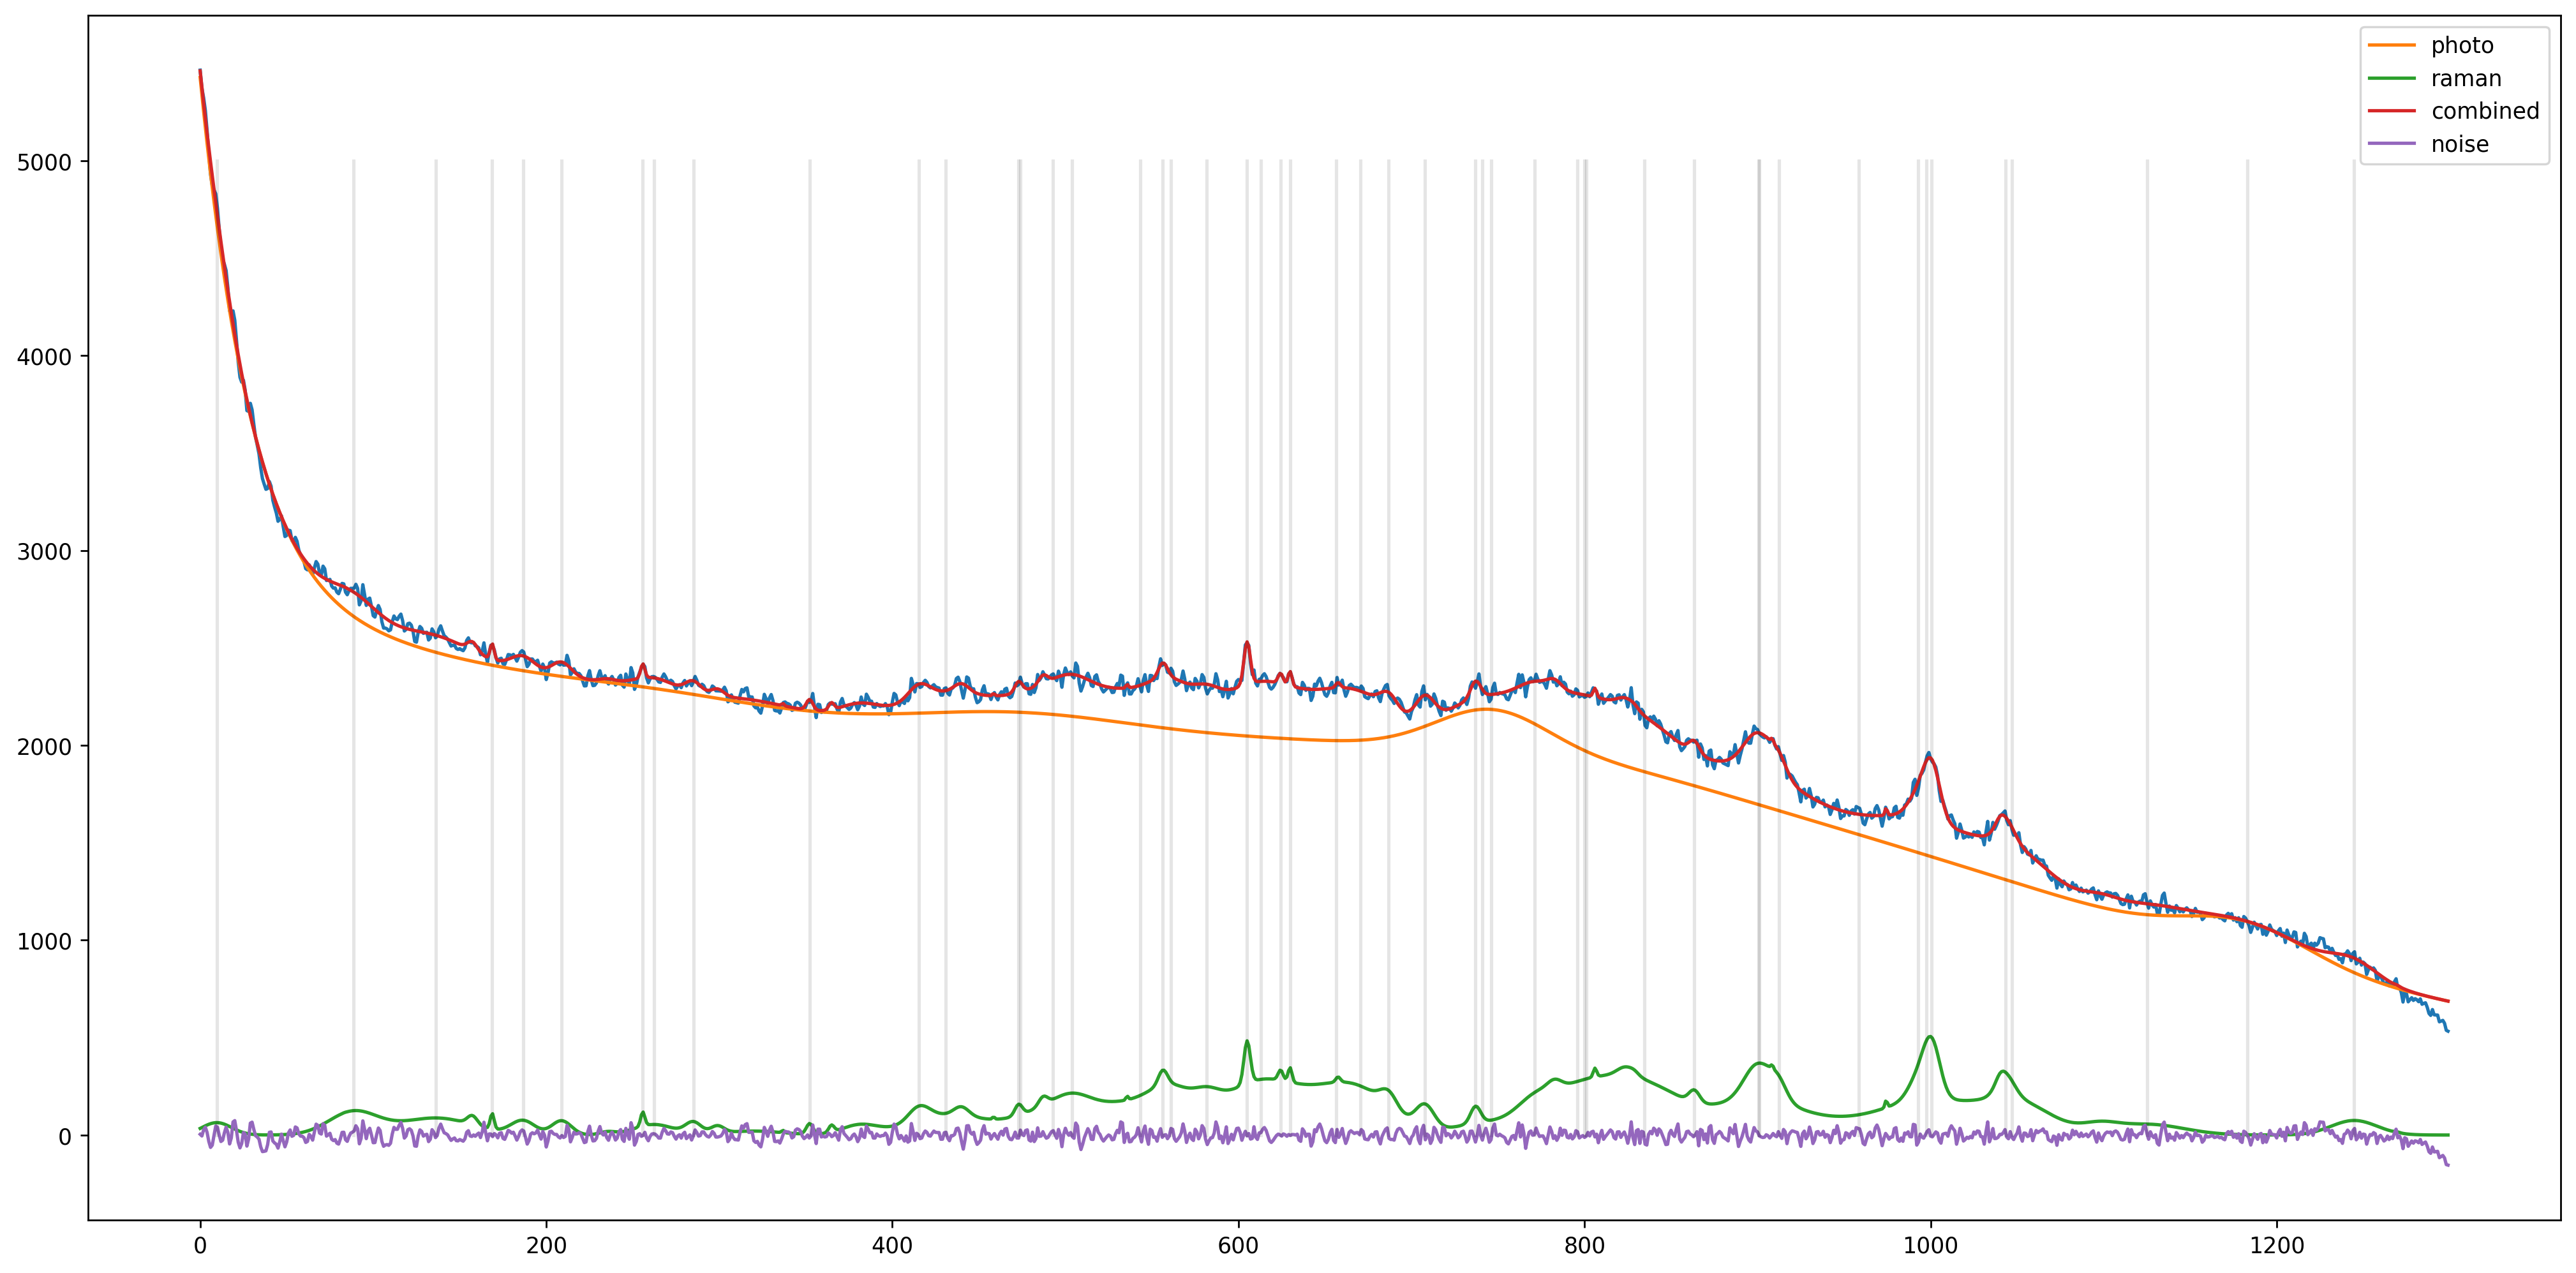

In [182]:
# photo_var = copy.copy(popt3)
# photo_var[slice(1,len(spikes)*3,3)] = 0
# raman_var = copy.copy(popt3)
# raman_var[slice(len(spikes)*3+1,len(popt3),3)] = 0

photo_var = copy.copy(popt3)
raman_var = copy.copy(popt3)
for i, (mean, scale, width) in enumerate(guassian_var3):
    if width < 40:
        photo_var[i*3+1] = 0
    else:
        raman_var[i*3+1] = 0

photo = func(x, *photo_var)
raman = func(x, *raman_var)

plt.plot(x, y)
plt.plot(x, photo, label='photo')
plt.plot(x, raman, label='raman')
plt.plot(x, photo+raman, label='combined')
plt.plot(x, y-photo-raman, label='noise')
for (mean, scale, width) in guassian_var3:
    if mean > 0 and mean < 1300 and scale > 50:
        plt.plot([mean, mean], [0, 5000], 'k',alpha=0.1)
plt.legend()
plt.show()



In [169]:
guassian_var3

array([[-365.000, 1000000.000, 150.000],
       [-1400.000, 5000.000, 1800.000],
       [800.000, 750.000, 400.000],
       [9.594, 63.569, 12.097],
       [33.496, 0.000, 1.015],
       [29.074, 0.000, 15.000],
       [61.000, 0.000, 1.234],
       [83.429, 0.918, 1.001],
       [88.527, 118.048, 20.067],
       [157.308, 46.493, 4.080],
       [168.745, 81.118, 1.613],
       [186.563, 70.353, 9.854],
       [208.811, 72.932, 8.035],
       [235.263, 15.098, 6.421],
       [255.757, 72.738, 1.703],
       [262.239, 54.064, 16.097],
       [285.032, 59.530, 6.522],
       [298.860, 37.970, 5.429],
       [319.599, 20.298, 24.334],
       [336.768, 12.039, 1.000],
       [352.210, 54.552, 2.699],
       [364.826, 35.717, 2.212],
       [381.119, 49.115, 14.808],
       [415.440, 74.631, 8.808],
       [439.896, 45.249, 6.171],
       [441.245, 8.378, 23.202],
       [458.493, 11.657, 1.000],
       [472.969, 56.035, 3.101],
       [487.115, 44.139, 3.676],
       [503.957, 53.350, 14.1